## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import m5.config as cfg
from m5.utils import get_columns
from m5.evaluate import calculate_rmsse

import lightgbm as lgb
import gc

# Library settings
pd.options.display.max_columns = 999
plt.rcParams["figure.figsize"] = (14, 4)

## Preprocessing

## Train

In [3]:
train = lgb.Dataset(str(cfg.DATA_DIR / "processed/datasets/12/train.bin"))
val = lgb.Dataset(str(cfg.DATA_DIR / "processed/datasets/12/val.bin"))

In [4]:
lgbm_params = {
    "task": "train",
    "objective": "tweedie",
    "num_iterations": 1000,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "num_threads": 4,
    "early_stopping_round": 100,
}

In [5]:
model = lgb.train(lgbm_params, train, valid_sets=[val])

/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Load from binary file /home/ariel/Playground/m5-forecasting/data/processed/datasets/12/train.bin
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.145739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6157
[LightGBM] [Info] Number of data points in the train set: 43838692, number of used features: 27
[LightGBM] [Info] Start training from score 0.355291
[1]	valid_0's tweedie: 4.59732
Training until validation scores don't improve for 100 rounds
[2]	valid_0's tweedie: 4.50064
[3]	valid_0's tweedie: 4.41692
[4]	valid_0's tweedie: 4.34572
[5]	valid_0's tweedie: 4.28488
[6]	valid_0's tweedie: 4.23276
[7]	valid_0's tweedie: 4.18844
[8]	valid_0's tweedie: 4.15063
[9]	valid_0's tweedie: 4.11808
[10]	valid_0's tweedie: 4.09085
[11]	valid_0's tweedie: 4.06696
[12]	valid_0's tweedie: 4.04719
[13]	valid_0's tweedie: 4.03
[14]	va

In [6]:
model.save_model(str(cfg.ROOT_DIR / "models/model_12.txt"))

## Predict

In [4]:
val = pd.read_parquet(cfg.DATA_DIR / "processed/datasets/12/val.parquet")

In [5]:
train = pd.read_parquet(cfg.DATA_DIR / "processed/datasets/12/train.parquet")

In [6]:
model = lgb.Booster(model_file=str(cfg.MODEL_DIR / "model_12.txt"))

In [7]:
fcst_df = val[["item_id", "store_id", "d", "sales"]].copy()
fcst_df["fcst"] = model.predict(val.drop(columns=["sales"]))

In [8]:
fcst_df

,item_id,store_id,d,sales,fcst
1885,0,0,1886,2,0.444386
1886,0,0,1887,1,0.442927
1887,0,0,1888,1,0.449601
1888,0,0,1889,0,0.508739
1889,0,0,1890,4,0.548512
...,...,...,...,...,...
45942495,3048,9,1909,0,0.099436
45942496,3048,9,1910,0,0.089450
45942497,3048,9,1911,0,0.083703
45942498,3048,9,1912,0,0.107511


(1800.0, 1920.0)

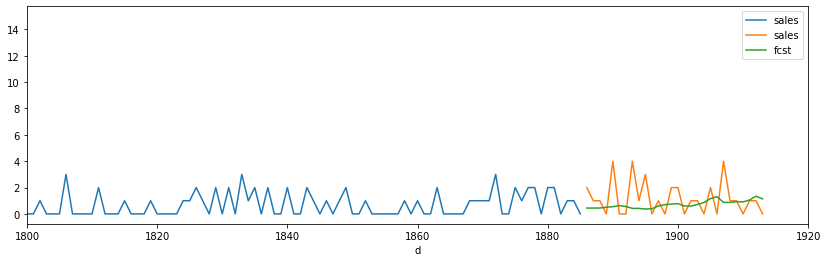

In [9]:
ID = (0, 0)
f, ax = plt.subplots()
train.loc[(train.item_id == ID[0]) & (train.store_id == ID[1]), ["sales", "d"]].set_index("d").plot(ax=ax)
fcst_df.loc[(fcst_df.item_id == ID[0]) & (fcst_df.store_id == ID[1]), ["sales", "fcst", "d"]].set_index("d").plot(ax=ax)
plt.xlim(left=1800, right=1920)

## Evaluate

In [62]:
data = pd.read_parquet(cfg.DATA_DIR / "processed/levels/level-12.parquet")

In [63]:
data = data.loc[data.d < 1886, ["item_id", "store_id", "d", "sales", "dollar_sales"]]

In [64]:
data

,item_id,store_id,d,sales,dollar_sales
0,0,0,1,3,6.0
1,0,0,2,0,0.0
2,0,0,3,0,0.0
3,0,0,4,1,2.0
4,0,0,5,4,8.0
...,...,...,...,...,...
45942467,3048,9,1881,0,0.0
45942468,3048,9,1882,0,0.0
45942469,3048,9,1883,0,0.0
45942470,3048,9,1884,0,0.0


In [101]:
total_dollar_sales = data["dollar_sales"].sum()
weights = data.groupby(["item_id", "store_id"])["dollar_sales"].agg(lambda x: x.sum() / total_dollar_sales).reset_index()
weights = weights.rename(columns={"dollar_sales": "weights"})

In [102]:
mse_naive_insample = data.groupby(["item_id", "store_id"])["sales"].agg(lambda x: (x.diff()**2).mean()).reset_index()
mse_naive_insample = mse_naive_insample.rename(columns={"sales": "mse_naive_insample"})

In [103]:
mse_fcst = fcst_df.groupby(["item_id", "store_id"]).apply(lambda df: ((df["sales"] - df["fcst"])**2).mean()).reset_index()
mse_fcst = mse_fcst.rename(columns={0: "mse_fcst"})

In [104]:
score_df = pd.merge(mse_fcst, mse_naive_insample, on=["item_id", "store_id"])

In [106]:
score_df["msse"] = score_df["mse_fcst"] / score_df["mse_naive_insample"]

In [107]:
score_df["rmsse"] = np.sqrt(score_df["msse"])

In [111]:
score_df = score_df.merge(weights, on=["item_id", "store_id"])

In [116]:
score_df

,item_id,store_id,mse_fcst,mse_naive_insample,msse,rmsse,weights
0,0,0,1.988412,2.899682,0.685735,0.828091,0.000017
1,0,1,7.502272,5.586518,1.342925,1.158846,0.000025
2,0,2,6.355793,10.154459,0.625912,0.791146,0.000027
3,0,3,0.413587,1.023367,0.404144,0.635723,0.000008
4,0,4,0.306272,3.511949,0.087208,0.295311,0.000013
...,...,...,...,...,...,...,...
30485,3048,5,0.212468,0.622411,0.341363,0.584262,0.000015
30486,3048,6,0.136353,0.223992,0.608741,0.780218,0.000007
30487,3048,7,0.041832,0.172780,0.242110,0.492047,0.000005
30488,3048,8,0.038144,0.069843,0.546134,0.739009,0.000002


In [122]:
score_df["weights"].sum()

1.000001

In [124]:
wrmsse = (score_df["rmsse"] * score_df["weights"]).sum()
wrmsse

0.7562451690119268

## Playground